# California Freshwater

### The following notebook cleans California freshwater consumption data and begins preliminary analysis.

Ultimately, the goal of this notebook and the accompanying Stata do file is to explore the relationship between ownership structures and water consumption. The central question I am interested in answering is the following: are private, for-profit water utilities more effective at managing water resources?

In [1]:
# Import relevant packages
import pandas as pd
import numpy as np

import os

import geopandas
from shapely.geometry import Point

import re

import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.animation as ani
import matplotlib.font_manager as font_manager
import seaborn as sns

from PIL import Image

from scipy.stats import gaussian_kde
from scipy.stats import kstest
from scipy.stats import ks_2samp
from scipy import stats

from sklearn import linear_model
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.formula.api import ols

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from linearmodels import PanelOLS

calwater_rawpath = r"D:\Dropbox\steiner_research\calwater_project\calwater_data_raw"
calwater_savepath = r"D:\Dropbox\steiner_research\calwater_project\calwater_data_clean"

calwater_output = r"D:\Dropbox\steiner_research\calwater_project\calwater_output"

 ## California Public Utilities Commission (CPUC)
 
The CPUC regulates utility companies in California and compiled a list of regulated water utilities' total service connections. The original file is stored in PDF format so I have used Amazon Web Services' Textract tool to convert the PDF into separate CSV files. Below, I read each table into dataframes before appending them into a single dataframe. We will use this later on when determining which water utilities are for-profit private.

In [2]:
# Use CSV tables created via AWS' Textract
classa_utility = pd.read_csv(calwater_rawpath + r"\cpuc_classutilities_textract\table-3_classa.csv", usecols=[0,1,2,3])

classa_utility['class'] = 'a'

classb_utility = pd.read_csv(calwater_rawpath + r"\cpuc_classutilities_textract\table-2_classb.csv", usecols=[0,1,2,3])

classb_utility['class'] = 'b'

classc_utility = pd.read_csv(calwater_rawpath + r"\cpuc_classutilities_textract\table-6_classc.csv", usecols=[0,1,2,3])

classc_utility['class'] = 'c'

classd_utility1 = pd.read_csv(calwater_rawpath + r"\cpuc_classutilities_textract\table-5_classd_pt1.csv", usecols=[0,1,2,3])

classd_utility1['class'] = 'd'

classd_utility2 = pd.read_csv(calwater_rawpath + r"\cpuc_classutilities_textract\table-7_classd_pt2.csv", usecols=[0,1,2,3])

classd_utility2['class'] = 'd'

classd_utility3 = pd.read_csv(calwater_rawpath + r"\cpuc_classutilities_textract\table-8_classd_pt3.csv", usecols=[0,1,2,3])

classd_utility3['class'] = 'd'

water_private = classa_utility.append(classb_utility).append(classc_utility).append(classd_utility1)
water_private = water_private.append(classd_utility2).append(classd_utility3)

water_private.columns = [col.lower().strip() for col in water_private.columns]

water_private['utility'] = water_private['utility'].str.strip()
water_private['utility'] = water_private['utility'].str.lower()

water_private['utility'] = water_private['utility'].str.replace('([ ]?\*[ ]?20[012][0-9] ar\*)', '', regex=True)
# water_private['utility'] = water_private['utility'].str.replace('(alisal)', 'alco', regex=True)
# water_private['utility'] = water_private['utility'].str.replace('( \(alco\))', '', regex=True)

water_private = water_private[(water_private['utility']!='total class a') &
                              (water_private['utility']!='total class b') &
                              (water_private['utility']!='total class c') &
                              (water_private['utility']!='total class d') &
                              (water_private['utility'].isnull()==0) &
                              (water_private['utility']!='grand total water')].reset_index().drop('index', axis=1)

water_private.sort_values('utility', inplace=True)

water_private['for_profit'] = 1

water_private['utility'].unique()[:20]

array(['agate bay water company', 'alisal water corporation (alco)',
       'alpine village water company', 'arroyo center water company',
       'bakman water company', 'bass lake water company',
       'baycliff water', 'big basin water company',
       'california hot springs water & sewer company',
       'california water service company',
       'california-american water company', 'canada woods water company',
       'casmite corporation, the', 'cazadero water company',
       'central camp water company', 'cobb mountain water company',
       'cold springs water company', 'cottage springs water company',
       'del oro water company', 'east pasadena water company'],
      dtype=object)

## California Natural Resources Agency (CNRA)

The CNRA compiled water consumption reports from urban water suppliers for June 2014 to January 2021.

In [3]:
calwater = pd.read_csv(calwater_rawpath + r"\canra_watersuppliermonitoring.csv", low_memory=False)

In [4]:
calwater['supplier_name'] = calwater['supplier_name'].str.lower()
calwater['supplier_name'] = calwater['supplier_name'].str.strip()

calwater.sort_values('supplier_name', inplace=True)

calwater['supplier_name2'] = calwater['supplier_name']

## NOTE: The following utilities have multiple districts they oversee. One variable, supplier_name, will have them separated
##       while the other, supplier_name2, will have them grouped together.
calwater['supplier_name2'] = calwater['supplier_name2'].str.replace('^(california water service company.*)$', 
                                                                    'california water service company', regex=True)
calwater['supplier_name2'] = calwater['supplier_name2'].str.replace('^(california-american water company.*)$', 
                                                                    'california-american water company', regex=True)
calwater['supplier_name2'] = calwater['supplier_name2'].str.replace('^(california-american water ventura.*)$', 
                                                                    'california-american water company', regex=True)
calwater['supplier_name2'] = calwater['supplier_name2'].str.replace('^(golden state water company.*)$', 
                                                                    'golden state water company', regex=True)
calwater['supplier_name2'] = calwater['supplier_name2'].str.replace('^(great oaks water company.*)$', 
                                                                    'great oaks water company', regex=True)
calwater['supplier_name2'] = calwater['supplier_name2'].str.replace('^(san gabriel valley fontana water company)$', 
                                                                    'san gabriel valley water company', regex=True)

calwater['supplier_name2'] = calwater['supplier_name2'].str.replace(',', ' ', regex=True)
calwater['supplier_name2'] = calwater['supplier_name2'].str.replace('( +)', ' ', regex=True)

calwater['supplier_name'] = calwater['supplier_name'].str.replace(',', ' ', regex=True)
calwater['supplier_name'] = calwater['supplier_name'].str.replace('( +)', ' ', regex=True)

## These are nonprofit, private water utilities (compiled via web searches; see "mutual company list").
nonprofit = ['atascadero mutual water company', 'bellflower-somerset mutual water company',
             'lincoln avenue water company', 'montebello land and water company',
             'myoma dunes mutual water company', 'oildale mutual water company',
             'orange vale water company', 'park water company',
             'riverside highland water company', 'sunny slope water company',
             'valencia water company', 'january water company (ali mutual)',
             'valley water company', 'vaughn water company']

calwater.loc[calwater['supplier_name2'].isin(nonprofit), 'nonprofit'] = 1
calwater.loc[calwater['supplier_name2'].isin(nonprofit)==0, 'nonprofit'] = 0

calwater = calwater[calwater['supplier_name2'].isnull()==0]

calwater['county'] = calwater['county'].str.replace('Dinuba,Tulare', 'Tulare')

calwater['supplier_name2'].unique()[:20]

array(['adelanto city of', 'alameda county water district',
       'alco water service', 'alhambra city of', 'amador water agency',
       'american canyon city of', 'anaheim city of', 'anderson city of',
       'antioch city of', 'apple valley ranchos water company',
       'arcadia city of', 'arcata city of', 'arroyo grande city of',
       'arvin community services district',
       'atascadero mutual water company', 'atwater city of',
       'azusa city of', 'bakersfield city of', 'bakman water company',
       'banning city of'], dtype=object)

### Clean values and prepare for analysis

Merge list of private companies to water supplier report data; rename columns; and perform various final cleaning tasks before starting analysis.

In [5]:
calwater_priv = calwater.merge(water_private, left_on='supplier_name2', right_on='utility', how='left')

calwater_priv.loc[(calwater_priv['for_profit']==1) | (calwater_priv['nonprofit']==1), 'private'] = 1

priv_counties = list(calwater_priv.loc[calwater_priv['private']==1, 'county'].drop_duplicates())
priv_hydro = list(calwater_priv.loc[calwater_priv['private']==1, 'hydrologic_region'].drop_duplicates())

calwater_comp = calwater_priv[calwater_priv['hydrologic_region'].isin(priv_hydro)]

calwater_comp = calwater_comp.rename(columns={'calculated_total_potable_water_production_gallons_ag_excluded':'tot_waterprod_exclag',
                                              'reported_final_commercial_industrial_and_institutional_water':'ind_inst_waterprod',
                                              'reported_final_commercial_agricultural_water':'ag_report_waterprod',
                                              'calculated_commercial_agricultural_water_gallons':'ag_calc_waterprod',
                                              'reported_final_total_potable_water_production':'report_tot_waterprod', 
                                              'total_population_served':'population',
                                              'water_shortage_contingency_stage_invoked':'shortage_stage'})

calwater_comp = calwater_comp.drop(['active', 'inactive', 'total'], axis=1)

calwater_comp['share_resid'] = calwater_comp['final_percent_residential_use'] / 100

calwater_comp.loc[calwater_comp['for_profit']!= 1, 'for_profit'] = 0

calwater_comp.columns = [str(col) for col in calwater_comp.columns]

calwater_comp = calwater_comp[['supplier_name', 'supplier_name2', 'population', 'tot_waterprod_exclag', 'share_resid',
                               'county', 'hydrologic_region', 'for_profit', 'reporting_month', 
                               'shortage_stage', 'calculated_r_gpcd', 'private', 'nonprofit']]

# Convert to DateTime and create month variable
calwater_comp['reporting_month'] = pd.to_datetime(calwater_comp['reporting_month'], format='%Y-%m-%d')

calwater_comp = calwater_comp.rename(columns={'reporting_month':'date'})

calwater_comp['month'] = pd.DatetimeIndex(calwater_comp['date']).month

med_percapita = calwater_comp.groupby(['for_profit']).median()

med_percapita = med_percapita[['population', 'tot_waterprod_exclag', 'calculated_r_gpcd']]

med_percapita

# calwater_comp.head()

,population,tot_waterprod_exclag,calculated_r_gpcd
for_profit,,,
0.0,43328.0,181179000.0,87.04410
1.0,58039.0,210174172.0,77.75805


In [6]:



calwater_comp.dtypes

supplier_name                   object
supplier_name2                  object
population                     float64
tot_waterprod_exclag           float64
share_resid                    float64
county                          object
hydrologic_region               object
for_profit                     float64
date                    datetime64[ns]
shortage_stage                  object
calculated_r_gpcd              float64
private                        float64
nonprofit                      float64
month                            int64
dtype: object

In [7]:
# Import geopandas file
cal_counties = geopandas.read_file(calwater_rawpath + r"\ca-county-boundaries\CA_Counties\CA_Counties_TIGER2016.shp")

cal_counties.rename(columns={'NAME':'county'}, inplace=True)

cal_counties['county'].tail()

53          San Mateo
54           Siskiyou
55         Santa Cruz
56              Glenn
57    San Luis Obispo
Name: county, dtype: object

In [8]:
def water_agg(fun, bool):
    water_df = fun

    water_df.reset_index(inplace=True)

    water_df['type'] = 'public'
    water_df.loc[water_df['for_profit']==1, 'type'] = 'for_profit'
    water_df.loc[water_df['nonprofit']==1, 'type'] = 'nonprofit'

    water_df = water_df.drop(['for_profit', 'nonprofit'], axis=1)
    
    # Allow for time grouping
    if bool == False:
        water_df = water_df.melt(id_vars=['county', 'type']).drop('variable', axis=1)
        water_df = water_df.pivot(index='county', columns='type', values='value').reset_index()
    if bool == True:
        water_df = water_df.melt(id_vars=['county', 'type', 'date']).drop('variable', axis=1)
        water_df = pd.pivot_table(water_df, index=['county', 'date'], columns='type', values='value').reset_index()
        print(water_df.head())
    
    water_df = pd.merge(right=water_df, left=cal_counties, on=['county'], how='outer')
    
#     water_df.fillna(value=0, inplace=True)
    
    return water_df

In [9]:
# Create dataframe that will show geographic distribution of utilities by county
water_comp = calwater_comp[['supplier_name2', 'county', 'for_profit', 'nonprofit']]
water_comp = water_comp.drop_duplicates()

water_comp = water_comp.set_index(['supplier_name2', 'for_profit', 'nonprofit']).apply(lambda x: x.str.split(',').explode()).reset_index()

water_comp = water_agg(water_comp.groupby(['county', 'for_profit', 'nonprofit']).count(), False)

water_comp.head(2)

,STATEFP,COUNTYFP,COUNTYNS,GEOID,county,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,for_profit,nonprofit,public
0,06,091,00277310,06091,Sierra,Sierra County,06,H1,G4020,None,...,None,A,2468694587,23299110,+39.5769252,-120.5219926,"POLYGON ((-13431319.751 4821511.426, -13431312...",NaN,NaN,NaN
1,06,067,00277298,06067,Sacramento,Sacramento County,06,H1,G4020,472,...,None,A,2499183617,76073827,+38.4500114,-121.3404409,"POLYGON ((-13490651.476 4680831.603, -13490511...",2.0,1.0,12.0


In [10]:
# Create dataframe that will show average consumption across time by county
water_avg = calwater_comp[['supplier_name2', 'county', 'for_profit', 'nonprofit', 'calculated_r_gpcd']]

water_avg = water_avg.set_index(['supplier_name2', 'for_profit', 'nonprofit', 'calculated_r_gpcd']).apply(lambda x: x.str.split(',').explode()).reset_index()

water_avg = water_agg(water_avg.groupby(['county', 'for_profit', 'nonprofit']).mean(), False)

water_avg.head(2)

,STATEFP,COUNTYFP,COUNTYNS,GEOID,county,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,for_profit,nonprofit,public
0,06,091,00277310,06091,Sierra,Sierra County,06,H1,G4020,None,...,None,A,2468694587,23299110,+39.5769252,-120.5219926,"POLYGON ((-13431319.751 4821511.426, -13431312...",NaN,NaN,NaN
1,06,067,00277298,06067,Sacramento,Sacramento County,06,H1,G4020,472,...,None,A,2499183617,76073827,+38.4500114,-121.3404409,"POLYGON ((-13490651.476 4680831.603, -13490511...",121.888252,177.446477,142.152343


In [11]:
# Create dataframe that will show average consumption across time by county
water_avg_time = calwater_comp[['supplier_name2', 'county', 'for_profit', 'nonprofit', 'calculated_r_gpcd', 'date']]

water_avg_time = water_avg_time.set_index(['supplier_name2', 'for_profit', 'nonprofit', 'calculated_r_gpcd', 'date']).apply(lambda x: x.str.split(',').explode()).reset_index()

water_avg_time = water_agg(water_avg_time.groupby(['county', 'for_profit', 'nonprofit', 'date']).mean(), True)

# water_avg_time.drop(water_avg_time[water_avg_time['date']==0].index, axis=0, inplace=True)

water_avg_time.set_index('date', inplace=True)

water_avg_time.head(2)

type   county       date  for_profit  nonprofit     public
0     Alameda 2014-06-15    137.0430        NaN  93.731233
1     Alameda 2014-07-15    126.0120        NaN  82.163414
2     Alameda 2014-08-15    120.9490        NaN  86.029843
3     Alameda 2014-09-15    114.5590        NaN  80.257900
4     Alameda 2014-10-15     98.8839        NaN  74.809386


,STATEFP,COUNTYFP,COUNTYNS,GEOID,county,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,for_profit,nonprofit,public
date,,,,,,,,,,,,,,,,,,,,,
NaT,06,091,00277310,06091,Sierra,Sierra County,06,H1,G4020,None,...,None,A,2468694587,23299110,+39.5769252,-120.5219926,"POLYGON ((-13431319.751 4821511.426, -13431312...",NaN,NaN,NaN
2014-06-15,06,067,00277298,06067,Sacramento,Sacramento County,06,H1,G4020,472,...,None,A,2499183617,76073827,+38.4500114,-121.3404409,"POLYGON ((-13490651.476 4680831.603, -13490511...",177.2555,372.693,240.635273


## Analysis

Our principle variable of concern is "calculated_r_gpcd", or Residential Gallons Per Capita Day (GPCD). Water suppliers report estimates of the gallons of water per person per day by residential customers it serves. GPCD is calculated using the following formula:

$$
\frac{[\frac{(TMP * PRU * C)}{TPS} ]}{MD},
$$

where TMP = Total monthly potable water production; PRU = percent residential use; C = Unit conversion factor; TPS = total population served; and MD = number of days in the month. Unit conversion factor refers to methods of converting the water suppliers' potable water unit of choice to gallons \[i.e., Million Gallons (MG) = 1,000,000 gallons (G)\].

By analyzing GPCD, we can better understand water consumption under various ownership schemes.

In [12]:
calwater_comp_check = calwater_comp[['county', 'for_profit']].drop_duplicates()

# calwater_comp_check.melt(id_vars='county')

# calwater_comp_check.sort_values('county')

In [13]:
# Set font size and labels to be used for all plots
fstitle_size = 24
ftitle_size = 20
flab_size = 18
ftick_size = 14
fannot_size = 14
font_name = 'Cambria'

suptitle_kws = {'fontname':font_name, 'fontsize':fstitle_size}
title_kws = {'fontname':font_name, 'fontsize':ftitle_size}
leg_kws = {'fontname':font_name, 'fontsize':flab_size}
lab_kws = {'fontname':font_name, 'fontsize':flab_size}
tick_kws = {'fontname':font_name, 'fontsize':ftick_size}
annot_kws = {'fontname':font_name, 'fontsize':fannot_size}

font = font_manager.FontProperties(family='Cambria', size=14)

In [14]:
def county_graphs(val, cat, title, np_max, fp_max, pub_max, time_bool, time):
    fig, (gax0, gax1, gax2) = plt.subplots(nrows=1, ncols=3, figsize=(20, 6.5))

    cal_counties.plot(ax=gax0, edgecolor='black', color='white', hatch='///')
    cal_counties.plot(ax=gax1, edgecolor='black', color='white', hatch='///')
    cal_counties.plot(ax=gax2, edgecolor='black', color='white', hatch='///')
# , missing_kwds={'color':'snow', 'hatch':'///', 'label':'N/A'}
    if cat == True:
        val.plot(ax=gax0, column='nonprofit', edgecolor='black', legend=True, 
                 cmap='Reds', categorical=cat)
        val.plot(ax=gax1, column='for_profit', edgecolor='black', legend=True, 
                 cmap='Blues', categorical=cat)
        val.plot(ax=gax2, column='public', edgecolor='black', legend=True, 
                 cmap='Greens', categorical=cat)

    if cat == False:
        val.plot(ax=gax0, column='nonprofit', edgecolor='black', legend=True, cmap='Reds', 
                 categorical=cat, vmax=np_max, vmin=0)
        val.plot(ax=gax1, column='for_profit', edgecolor='black', legend=True, cmap='Blues', 
                 categorical=cat, vmax=fp_max, vmin=0)
        val.plot(ax=gax2, column='public', edgecolor='black', legend=True, cmap='Greens', 
                 categorical=cat, vmax=pub_max, vmin=0)

    gax0.set_title('Non-Profit', **title_kws)
    gax1.set_title('For-Profit', **title_kws)
    gax2.set_title('Public', **title_kws)

    for gax in (gax0, gax1, gax2):
        gax.spines['top'].set_visible(False)
        gax.spines['right'].set_visible(False)
        gax.spines['left'].set_visible(False)
        gax.spines['bottom'].set_visible(False)
        gax.tick_params(axis='x', bottom=False, top=False, labelbottom=False)
        gax.tick_params(axis='y', right=False, left=False, labelleft=False)

        gax.xaxis.get_offset_text().set_visible(False)

    if time_bool == True:
        fig.suptitle(title + '\n' + time, **suptitle_kws)
        
    if time_bool == False:
        fig.suptitle(title, **suptitle_kws)

    chart = plt.gcf()
    
    return chart
    

### Geographic distribution of urban water suppliers by ownership scheme

Below, three maps reflect the geographic distribution of water suppliers by ownership type. Unsurprisingly, there is a large concentration of active water suppliers in the densely populated Los Angeles area and the Southern California area more generally.

In [15]:
# water_comp.head()

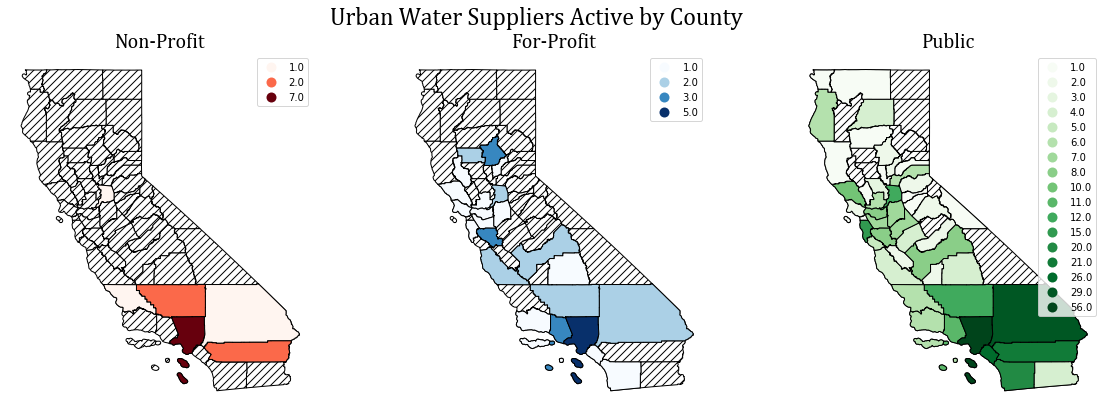

In [16]:
sup_map = county_graphs(water_comp, True, 'Urban Water Suppliers Active by County', water_comp['nonprofit'].max(), 
                        water_comp['for_profit'].max(), water_comp['public'].max(), False, '')

With a better understanding of the suppliers' geographic distribution, we can begin to understand the nature of statewide water consumption. We begin by exploring mean urban water consumption by county; this was done by taking the average across time and suppliers by county. Clearly, counties have very different consumption habits within ownership groups; interestingly, certain counties appear to be higher consumers of water across counties, suggesting that we may want to include county controls in our final model. 

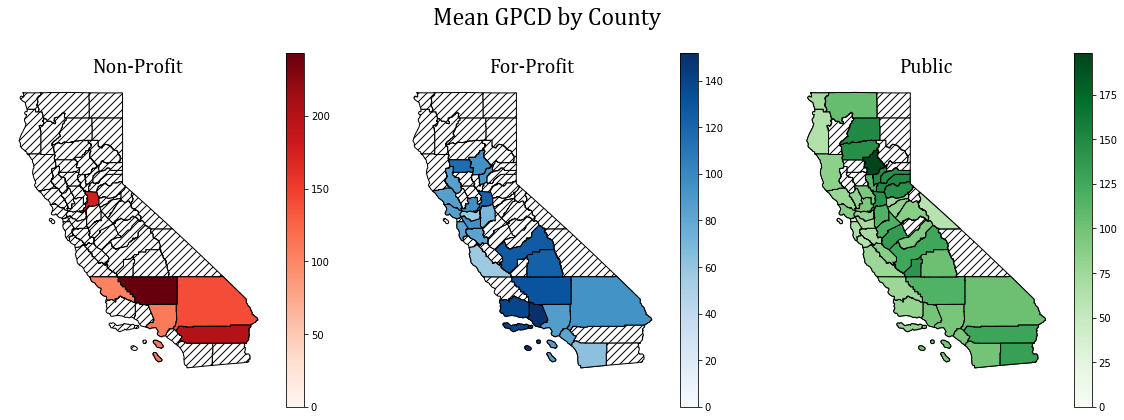

In [17]:
cons_map = county_graphs(water_avg, False, 'Mean GPCD by County', water_avg['nonprofit'].max(), 
                         water_avg['for_profit'].max(), water_avg['public'].max(), False, '')

C:\Users\Admin\anaconda3\lib\site-packages\geopandas\plotting.py:607: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


KeyboardInterrupt: 

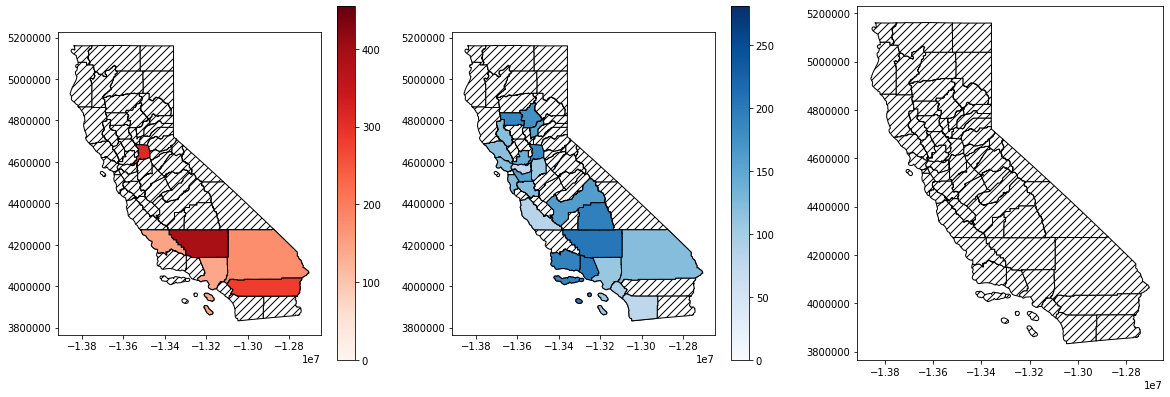

In [18]:
# if os.path.exists(calwater_output + r'\mean_water') == False:
#     print(calwater_output + r'\mean_water')
#     os.makedirs(calwater_output + r'\mean_water')

# cons_map_time = county_graphs(water_avg_time[water_avg_time.index==pd.to_datetime('2020-10-15')], 
#                               False, 'Mean Urban Water Consumption by County', water_avg_time['nonprofit'].max(), 
#                               water_avg_time['for_profit'].max(), water_avg_time['public'].max(), True, '2020-10-15')
    
# cons_map_time.savefig(calwater_output + r'\mean_water\2020-10-15.jpg', dpi=400)

# plot_max = max([water_avg_time['nonprofit'].max(), water_avg_time['for_profit'].max(), water_avg_time['public'].max()])
    
time_map_dir = calwater_output + r'\mean_water'

for dat in water_avg_time.index:
    cons_map_time = county_graphs(water_avg_time[water_avg_time.index==dat], 
                                  False, 'Mean GPCD by County', water_avg_time['nonprofit'].max(), 
                                  water_avg_time['for_profit'].max(), water_avg_time['public'].max(), True, str(dat)[:10])
    cons_map_time.savefig(time_map_dir + r'\\' + str(dat)[:10] + '.jpg', dpi=300)
    
    plt.close()
    

In [19]:
image_dirlist = os.listdir(time_map_dir)

images = [Image.open(time_map_dir + r'\\' + im) for im in image_dirlist]
gif = []

for wtrmap in images:
    gif.append(wtrmap)
    
gif[0].save(calwater_output + r'\wtrmap_timelapse.gif', save_all=True, optimize=False, append_images=gif[1:], loop=0)


### Understanding GPCD

Before moving onto regression analysis, we must better understand the GPCD variable and check that it closely follows a normal distribution. Upon checking its density plot, we can see that it has a very long right tail; this may upwardly skew estimates (demonstrated by the location of each graph's median line) so we ought to take the log of GPCD. In the next graph, we can see that log GPCD more closely follows a normal distribution, making log GPCD a more appropriate independent variable.

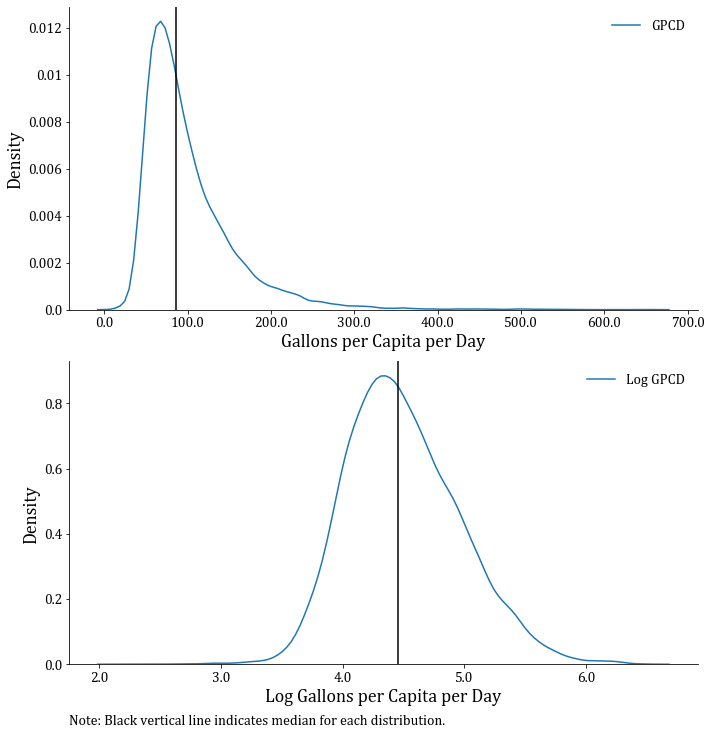

In [20]:
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

calwater_comp['log_gpcd'] = np.log(calwater_comp['calculated_r_gpcd'])

gpcd0 = sns.kdeplot(calwater_comp['calculated_r_gpcd'], ax=ax0, label='GPCD')
gpcd1 = sns.kdeplot(calwater_comp['log_gpcd'], ax=ax1, label='Log GPCD')

# print(calwater_comp['calculated_r_gpcd'].median())

ax0.axvline(x=calwater_comp['calculated_r_gpcd'].median(), color='black')
ax1.axvline(x=calwater_comp['log_gpcd'].median(), color='black')

for ax in (ax0, ax1):
    ax.legend(frameon=False, prop=font)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_ylabel('Density', **lab_kws)

    ax.set_xticklabels(ax.get_xticks(), **tick_kws)
    
ax0.set_yticklabels(ax0.get_yticks(), **tick_kws)
ax1.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], **tick_kws)

ax0.set_xlabel('Gallons per Capita per Day', **lab_kws)
ax1.set_xlabel('Log Gallons per Capita per Day', **lab_kws)

# ax1 = fig.add_axes([0.25, 0, 0, 0])

fig.tight_layout()

ax1.annotate('Note: Black vertical line indicates median for each distribution.', 
             xy=(0, -.2), xycoords='axes fraction', **annot_kws)

plt.show()

### Comparing GPCD distributions under different ownership

Before beginning regression analysis to explore ownership differences, we must make sure that the distributions differ by ownership group. After comparing nonprofit and for-profit against public, we can conclusively say that their GPCD distributions are significantly different (based on K-Smirnov test results) and may proceed with our regression analysis.

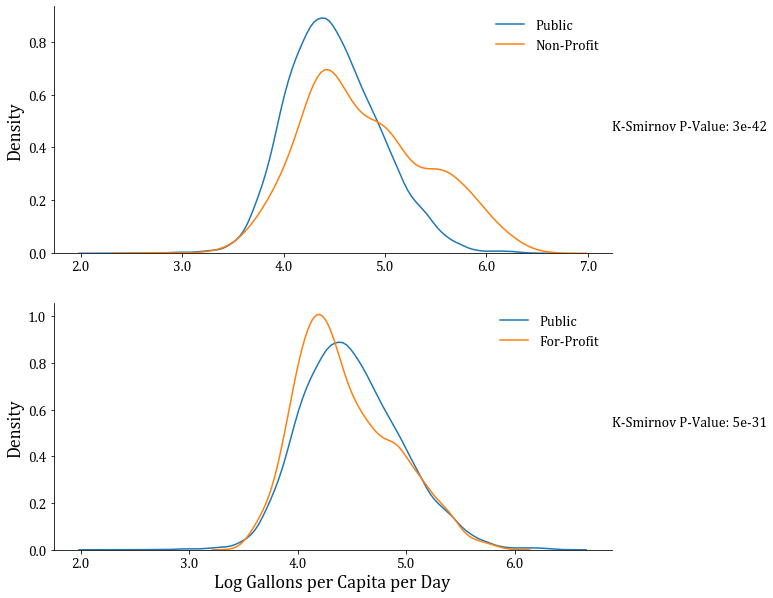

In [21]:
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

res0= ks_2samp(calwater_comp.loc[(calwater_comp['for_profit']==0)&(calwater_comp['nonprofit']==0), 'log_gpcd'],
               calwater_comp.loc[calwater_comp['nonprofit']==1, 'log_gpcd'])
res1= ks_2samp(calwater_comp.loc[(calwater_comp['for_profit']==0)&(calwater_comp['nonprofit']==0), 'log_gpcd'],
               calwater_comp.loc[calwater_comp['for_profit']==1, 'log_gpcd'])

prof0 = sns.kdeplot(calwater_comp.loc[(calwater_comp['for_profit']==0)&(calwater_comp['nonprofit']==0), 'log_gpcd'], 
                    ax=ax0, label='Public')
prof0 = sns.kdeplot(calwater_comp.loc[(calwater_comp['nonprofit']==1), 'log_gpcd'], 
                    ax=ax0, label='Non-Profit')

prof1 = sns.kdeplot(calwater_comp.loc[(calwater_comp['for_profit']==0)&(calwater_comp['nonprofit']==0), 'log_gpcd'],
                    ax=ax1, label='Public')
prof1 = sns.kdeplot(calwater_comp.loc[calwater_comp['for_profit']==1, 'log_gpcd'], 
                    ax=ax1, label='For-Profit')

for ax in (ax0, ax1):
    ax.legend(frameon=False, prop=font)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_ylabel('Density', **lab_kws)

    ax.set_xticklabels(ax.get_xticks(), **tick_kws)
    ax.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], **tick_kws)

res0_text = 'K-Smirnov P-Value: ' + str(round(res0[1], 42))
res1_text = 'K-Smirnov P-Value: ' + str(round(res1[1], 31))

# print(res0_text)

ax0.annotate(res0_text, xy=(1, .5), xycoords='axes fraction', **annot_kws)
ax1.annotate(res1_text, xy=(1, .5), xycoords='axes fraction', **annot_kws)

ax1.set_xlabel('Log Gallons per Capita per Day', **lab_kws)

plt.show()

In [22]:
calwater_comp.to_csv(calwater_savepath + r"\calwater_data.csv")

In [23]:
calwater_comp['nonprofit'].unique()

calwater_comp.loc[(calwater_comp['nonprofit']==0) & (calwater_comp['for_profit']==0), 'public'] = 1
calwater_comp.loc[(calwater_comp['nonprofit']==1) | (calwater_comp['for_profit']==1), 'public'] = 0

calwater_comp.loc[(calwater_comp['for_profit']==1), 'owner'] = 1
calwater_comp.loc[(calwater_comp['public']==1), 'owner'] = 2
calwater_comp.loc[(calwater_comp['nonprofit']==1), 'owner'] = 3

calwater_comp['public'].unique()

array([1., 0.])

## Regression analysis


In [24]:
model = linear_model.LinearRegression()

X = calwater_comp[['public', 'nonprofit']]
Y = calwater_comp['log_gpcd']

results1 = ols('log_gpcd ~ C(owner)', data=calwater_comp).fit()

print(results1.get_robustcov_results(cov_type='cluster', groups=calwater_comp['supplier_name']).summary())



                            OLS Regression Results                            
Dep. Variable:               log_gpcd   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     2.827
Date:                Mon, 06 Sep 2021   Prob (F-statistic):             0.0603
Time:                        21:26:22   Log-Likelihood:                -19929.
No. Observations:               30735   AIC:                         3.986e+04
Df Residuals:                   30732   BIC:                         3.989e+04
Df Model:                           2                                         
Covariance Type:              cluster                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           4.4423      0.050     

In [25]:
results2 = ols('log_gpcd ~ C(owner) + C(hydrologic_region)', data=calwater_comp).fit()

print(results2.get_robustcov_results(cov_type='cluster', groups=calwater_comp['supplier_name']).summary())

                            OLS Regression Results                            
Dep. Variable:               log_gpcd   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     19.85
Date:                Mon, 06 Sep 2021   Prob (F-statistic):           7.47e-30
Time:                        21:26:24   Log-Likelihood:                -17534.
No. Observations:               30735   AIC:                         3.509e+04
Df Residuals:                   30724   BIC:                         3.518e+04
Df Model:                          10                                         
Covariance Type:              cluster                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [26]:
results3 = ols('log_gpcd ~ C(owner) + C(hydrologic_region) + C(month)', data=calwater_comp).fit()

print(results3.get_robustcov_results(cov_type='cluster', groups=calwater_comp['supplier_name']).summary())

                            OLS Regression Results                            
Dep. Variable:               log_gpcd   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     147.5
Date:                Mon, 06 Sep 2021   Prob (F-statistic):          5.66e-175
Time:                        21:26:27   Log-Likelihood:                -12537.
No. Observations:               30735   AIC:                         2.512e+04
Df Residuals:                   30713   BIC:                         2.530e+04
Df Model:                          21                                         
Covariance Type:              cluster                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------